In [1]:
!pip install pyspark pillow numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=e6d92f3a3b2c338c99a76d1984000b2ff35d4b4c0d6ee40e3369a6d2c1b01101
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


###Cargar dataset en GoogleColab

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
!cp /content/drive/MyDrive/PetImages.zip .
!unzip PetImages -d "PetImages"

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Cat/1178.jpg  
  inflating: PetImages/Cat/1179.jpg  
  inflating: PetImages/Cat/118.jpg   
  inflating: PetImages/Cat/1180.jpg  
  inflating: PetImages/Cat/1181.jpg  
  inflating: PetImages/Cat/1182.jpg  
  inflating: PetImages/Cat/1183.jpg  
  inflating: PetImages/Cat/1184.jpg  
  inflating: PetImages/Cat/1185.jpg  
  inflating: PetImages/Cat/1186.jpg  
  inflating: PetImages/Cat/1187.jpg  
  inflating: PetImages/Cat/1188.jpg  
  inflating: PetImages/Cat/1189.jpg  
  inflating: PetImages/Cat/119.jpg   
  inflating: PetImages/Cat/1190.jpg  
  inflating: PetImages/Cat/1191.jpg  
  inflating: PetImages/Cat/1192.jpg  
  inflating: PetImages/Cat/1193.jpg  
  inflating: PetImages/Cat/1194.jpg  
  inflating: PetImages/Cat/1195.jpg  
  inflating: PetImages/Cat/1196.jpg  
  inflating: PetImages/Cat/1197.jpg  
  inflating: PetImages/Cat/1198.jpg  
  inflating: PetImages/Cat/1199.jpg  
  inflating: PetImages/Cat/12.jpg    

### Cargar datos desde archivo local a GoogleDrive y luego a Colab

In [3]:
#from google.colab import files
#uploades = files.upload()

In [4]:
# Descomprimir y establecer ruta del dataset
#import zipfile

#with zipfile.ZipFile("PetImages.zip","r") as zip_ref:
  #zip_ref.extractall("PetImages")

### Importar librerías necesarias

In [5]:
import os
import time
import numpy as np
from random import sample
from sklearn import metrics
import matplotlib.image as mpimg
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import StringType, ArrayType, IntegerType, FloatType
from pyspark.ml.feature import VectorAssembler, UnivariateFeatureSelector, StringIndexer
from pyspark.sql.functions import col, regexp_extract, collect_list, struct, mean, max, udf
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier, MultilayerPerceptronClassifier, LinearSVC

# Inicializar Spark

In [6]:
os.environ['SPARK_EXECUTOR_MEMORY'] = '4g'
os.environ['SPARK_DRIVER_MEMORY'] = '4g'
spark = SparkSession.builder.appName("BigDataProject").getOrCreate()
spark

# Ingesta de datos y preprocesamiento

### Cargar las imágenes a partir de la ruta especificada en un DataFrame

In [7]:
image_dir1 = "PetImages/Cat/"
image_dir2 = "PetImages/Dog/"

# cargar las primeras 50 imágenes de cada carpeta y guardarlas en dos listas respectivamente
image_paths1 = [os.path.join(image_dir1, filename) for filename in os.listdir(image_dir1)[:500]]
image_paths2 = [os.path.join(image_dir2, filename) for filename in os.listdir(image_dir2)[:500]]

image_paths = image_paths1 + image_paths2


In [8]:
df = spark.createDataFrame(image_paths, StringType()).toDF("image_path")

### Extraer etiquetas

In [9]:
#Definir función que tome la etiqueta del path de la columna
def extract_label(image_path):
  return regexp_extract(image_path,"PetImages/([^/]+)",1)

# definir el nuevo dataset con etiquetas str
df = df.select(col("image_path"),extract_label(col("image_path")).alias("labelstr"))


### Transformar las etiquetas en índices
#### Se recomienda esta transformación ya que  es necesario una representación más eficiente antes de utilizar un algoritmo de aprendizaje automático. Cada etiqueta es una cadena de caracteres y pueden llegar a ser pesadas en el uso de memoria.

In [10]:
# transformar etiquetas en índices
indexer = StringIndexer(inputCol="labelstr",outputCol="label")
df = indexer.fit(df).transform(df)

# guardar cada etiqueta con su nombre
classes = df.select(['labelstr','label']).distinct()
# definir el nuevo dataset con los nuevos indices
df = df.drop("labelstr")

In [11]:
df.show()
classes.show()

+--------------------+-----+
|          image_path|label|
+--------------------+-----+
|PetImages/Cat/144...|  0.0|
|PetImages/Cat/129...|  0.0|
|PetImages/Cat/201...|  0.0|
|PetImages/Cat/148...|  0.0|
|PetImages/Cat/492...|  0.0|
|PetImages/Cat/189...|  0.0|
|PetImages/Cat/215...|  0.0|
|PetImages/Cat/334...|  0.0|
|PetImages/Cat/624...|  0.0|
|PetImages/Cat/240...|  0.0|
|PetImages/Cat/433...|  0.0|
|PetImages/Cat/643...|  0.0|
|PetImages/Cat/151...|  0.0|
|PetImages/Cat/163...|  0.0|
|PetImages/Cat/532...|  0.0|
|PetImages/Cat/981...|  0.0|
|PetImages/Cat/30.jpg|  0.0|
|PetImages/Cat/134...|  0.0|
|PetImages/Cat/222...|  0.0|
|PetImages/Cat/236...|  0.0|
+--------------------+-----+
only showing top 20 rows

+--------+-----+
|labelstr|label|
+--------+-----+
|     Cat|  0.0|
|     Dog|  1.0|
+--------+-----+



# Ingeniería de rasgos

### Transformar las imágenes a un mismo tamaño y obtener su contenido en vectores

In [12]:
#Definir función que carga la imagen desde la ruta asignada y la transforma en el tamaño estándar especificado
def read_and_resize_image(image_path, target_size):
  image = Image.open(image_path)
  image = image.resize(target_size)
    # Normalizar los valores de los pixeles  entre 0 and 1
  image_array = np.array(image) / 255.0
  print(image_array)
   # convertir arreglo en lista para devolverla en vector de Spark
  return Vectors.dense(image_array.flatten().tolist())

In [13]:
# Registrar función en spark
resize_udf = udf(lambda path: read_and_resize_image(path, target_size=(224, 224)), VectorUDT())
spark.udf.register("resize_udf", resize_udf)

<function __main__.<lambda>(path)>

### Transformar las imágenes a un mismo tamaño y obtener su contenido en vectores
#### Esta vez, aplicando cambios en los canales de las imágenes. Esta conversión es para ayudar a detectar ruido en los datos.

In [14]:
# Definir función que carga la imagen desde la ruta asignada, opera rasgos y la transforma en el tamaño estándar especificado
def feature_and_resize_image(image_path, target_size):
  image = Image.open(image_path)
  image = image.resize(target_size)
  # transformarla a escala de grises
  image = image.convert('L')
  # transformar imágenes apliclando edges filter
  image = image.filter(ImageFilter.FIND_EDGES)
  # Normalizar los valores de los pixeles  entre 0 and 1
  image_array = np.array(image) / 255.0
  print(image_array)
  # convertir arreglo en lista para devolverla en vector de Spark
  return Vectors.dense(image_array.flatten().tolist())

In [15]:
# Registrar función en spark
feat_and_res_udf = udf(lambda path: feature_and_resize_image(path, target_size=(224, 224)), VectorUDT())
spark.udf.register("feature_and_resize_image", feat_and_res_udf)

<function __main__.<lambda>(path)>

#### Crear dataframe con las imágenes cargadas: su ruta, etiqueta y contenido

In [16]:
#Definir función que calcule el tam de todos los vectores
get_vector_size_udf = udf(lambda x: len(x), IntegerType())


In [17]:
# agregar columna features aplicando la función definida
df = df.withColumn("image_features", feat_and_res_udf("image_path"))

In [18]:
# mostrar otros datos como tipos de datos, tamaño de los vectores y cantidad total
df_sizes = df.withColumn("vector_sizes", get_vector_size_udf("image_features"))
df_sizes.printSchema()
df_sizes.show()
df_sizes.count()

root
 |-- image_path: string (nullable = true)
 |-- label: double (nullable = false)
 |-- image_features: vector (nullable = true)
 |-- vector_sizes: integer (nullable = true)

+--------------------+-----+--------------------+------------+
|          image_path|label|      image_features|vector_sizes|
+--------------------+-----+--------------------+------------+
|PetImages/Cat/144...|  0.0|[0.10588235294117...|       50176|
|PetImages/Cat/129...|  0.0|[0.35686274509803...|       50176|
|PetImages/Cat/201...|  0.0|[0.32549019607843...|       50176|
|PetImages/Cat/148...|  0.0|[0.62352941176470...|       50176|
|PetImages/Cat/492...|  0.0|[0.89411764705882...|       50176|
|PetImages/Cat/189...|  0.0|[0.49803921568627...|       50176|
|PetImages/Cat/215...|  0.0|[0.33725490196078...|       50176|
|PetImages/Cat/334...|  0.0|[0.20392156862745...|       50176|
|PetImages/Cat/624...|  0.0|[0.22352941176470...|       50176|
|PetImages/Cat/240...|  0.0|[0.26666666666666...|       50176|
|Pet

1000

### Crear nuevo dataframe aplicando selección de rasgos

In [19]:
selector = UnivariateFeatureSelector(outputCol="selectedFeatures",selectionMode="percentile")
selector = selector.setFeatureType("continuous").setLabelType("categorical")
df_select = selector.setFeaturesCol("image_features").fit(df).transform(df)

df_select = df_select.withColumn("vectorSelected_sizes", get_vector_size_udf("selectedFeatures"))

In [20]:
max_value1 = df_sizes.select(max(df_sizes['vector_sizes'])).collect()[0][0]
max_value2 = df_select.select(max(df_select['vectorSelected_sizes'])).collect()[0][0]
print(f"Tamaño antes: {max_value1}")
print(f"Tamaño con selección de rasgos: {max_value2}")

Tamaño antes: 50176
Tamaño con selección de rasgos: 5017


# Flujo de trabajo de Machine Learning

## Entrenamiento del modelo

### Se establecen conjuntos de entrenamiento y prueba para el dataframe completo y el resultante de la seleccción de rasgos

In [21]:
# establecer los conjuntos de entrenamiento y de prueba
(trainData, testData) = df.randomSplit([0.8, 0.2], seed=34)
print(f"Datos de entrenamiento: {trainData.count()}")
print(f"Datos de prueba: {testData.count()}")

Datos de entrenamiento: 785
Datos de prueba: 215


In [22]:
(trainDataPlus, testDataPlus) = df_select.randomSplit([0.8, 0.2], seed=34)

### Crear y entrenar modelos con Decision Tree Classifier, usando el DF completo y el reducido

In [23]:
# Crear modelo decision tree
dtClassifier = DecisionTreeClassifier(labelCol="label", featuresCol="image_features")
# Entrenar decision tree model
inicio = time.time()
dtModel = dtClassifier.fit(trainData)
final =  time.time() - inicio
print(f"Tiempo que tarda en entrenar el modelo DT: {final/60} min")

Tiempo que tarda en entrenar el modelo DT: 4.371480619907379 min


In [24]:
# Crear modelo decision tree con seleccion
dtClassifierPlus = DecisionTreeClassifier(labelCol="label", featuresCol="selectedFeatures")
# Entrenar decision tree model
inicio = time.time()
dtModelPlus = dtClassifierPlus.fit(trainDataPlus)
final =  time.time() - inicio
print(f"Tiempo que tarda en entrenar el modelo DT con selección aplicada: {final/60} min")

Tiempo que tarda en entrenar el modelo DT con selección aplicada: 3.2880478421847026 min


### Crear y entrenar modelos con linearSVC Classifier(con LinearSupportVectorMachines), usando el DF completo y el reducido

In [25]:
# Crear modelo linearSVC
svcClassifier =LinearSVC(maxIter=500, regParam=0.1,featuresCol="image_features", labelCol="label")
# Entrenar linear model
inicio = time.time()
svcModel = svcClassifier.fit(trainData)
final =  time.time() - inicio
print(f"Tiempo que tarda en entrenar el modelo SVM: {final/60} min")

Tiempo que tarda en entrenar el modelo SVM: 4.721035718917847 min


In [26]:
# Crear modelo linearSVC con seleccion
svcClassifierPlus =LinearSVC(maxIter=500, regParam=0.1,featuresCol="image_features", labelCol="label")
# Entrenar linearSVC model
inicio = time.time()
svcModelPlus = svcClassifierPlus.fit(trainDataPlus)
final =  time.time() - inicio
print(f"Tiempo que tarda en entrenar el modelo SVM con selección aplicada: {final/60} min")

Tiempo que tarda en entrenar el modelo SVM con selección aplicada: 4.530937023957571 min


### Crear y entrenar modelos con MLP Classifier, usando el DF completo y el reducido

In [27]:
# Crear modelo MLP
# 4 capas: 1 de entrada(tantas neuronas como cant rasgos de img), 2 ocultas(con 93 neuronas mas o menos distribuidas entre si) y 1 de salida(con dos una pa c/clase)
layers = [len(trainData.select("image_features").take(1)[0][0]), 64, 32, 10]
mlpClassifier = MultilayerPerceptronClassifier(maxIter=500, layers=layers, blockSize=128, seed=1234, featuresCol="image_features", labelCol="label")
# Entrenar MLP model
inicio = time.time()
mlpModel = mlpClassifier.fit(trainData)
final =  time.time() - inicio
print(f"Tiempo que tarda en entrenar el modelo MLP: {final/60} min")

Tiempo que tarda en entrenar el modelo MLP: 3.8468745668729145 min


In [28]:
# Crear modelo MLP con seleccion
layers = [len(trainDataPlus.select("image_features").take(1)[0][0]), 64, 32, 10]
mlpClassifierPlus =MultilayerPerceptronClassifier(maxIter=500, layers=layers, blockSize=128, seed=1234, featuresCol="image_features", labelCol="label")
# Entrenar MLP
inicio = time.time()
mlpModelPlus = mlpClassifierPlus.fit(trainDataPlus)
final =  time.time() - inicio
print(f"Tiempo que tarda en entrenar el modelo MLP con selección aplicada: {final/60} min")

Tiempo que tarda en entrenar el modelo MLP con selección aplicada: 3.607135454813639 min


## Evaluación del modelo

In [29]:
# Usar evaluadores
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')

### Evaluar modelos DT

In [30]:
# Hacer predicciones de Decision Tree
predictions = dtModel.transform(testData)

# Obtener métricas
acc = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictions)

In [31]:
# Hacer predicciones de DecisionTree Model con seleccion
predictionsPlus = dtModelPlus.transform(testDataPlus)

# Obtener métricas
accPlus = evaluatorMulti.evaluate(predictionsPlus, {evaluatorMulti.metricName: "accuracy"})
f1Plus = evaluatorMulti.evaluate(predictionsPlus, {evaluatorMulti.metricName: "f1"})
weightedPrecisionPlus = evaluatorMulti.evaluate(predictionsPlus, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecallPlus = evaluatorMulti.evaluate(predictionsPlus, {evaluatorMulti.metricName: "weightedRecall"})
aucPlus = evaluator.evaluate(predictionsPlus)

### Evaluar modelos SVC

In [32]:
# Hacer predicciones de SVC Model
predictions_svc = svcModel.transform(testData)

# Obtener métricas
acc_svc = evaluatorMulti.evaluate(predictions_svc, {evaluatorMulti.metricName: "accuracy"})
f1_svc = evaluatorMulti.evaluate(predictions_svc, {evaluatorMulti.metricName: "f1"})
weightedPrecision_svc = evaluatorMulti.evaluate(predictions_svc, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall_svc = evaluatorMulti.evaluate(predictions_svc, {evaluatorMulti.metricName: "weightedRecall"})
auc_svc = evaluator.evaluate(predictions_svc)

In [33]:
# Hacer predicciones de SVC Model con seleccion
predictions_svcPlus = svcModelPlus.transform(testDataPlus)

# Obtener métricas
acc_svcPlus = evaluatorMulti.evaluate(predictions_svcPlus, {evaluatorMulti.metricName: "accuracy"})
f1_svcPlus = evaluatorMulti.evaluate(predictions_svcPlus, {evaluatorMulti.metricName: "f1"})
weightedPrecision_svcPlus = evaluatorMulti.evaluate(predictions_svcPlus, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall_svcPlus = evaluatorMulti.evaluate(predictions_svcPlus, {evaluatorMulti.metricName: "weightedRecall"})
auc_svcPlus = evaluator.evaluate(predictions_svcPlus)

### Evaluar modelos MLP

In [34]:
# Hacer predicciones de MLP Model
predictions_mlp = mlpModel.transform(testData)

# Obtener métricas
acc_mlp = evaluatorMulti.evaluate(predictions_mlp, {evaluatorMulti.metricName: "accuracy"})
f1_mlp = evaluatorMulti.evaluate(predictions_mlp, {evaluatorMulti.metricName: "f1"})
weightedPrecision_mlp = evaluatorMulti.evaluate(predictions_mlp, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall_mlp = evaluatorMulti.evaluate(predictions_mlp, {evaluatorMulti.metricName: "weightedRecall"})
auc_mlp = evaluator.evaluate(predictions_mlp)

In [35]:
# Hacer predicciones de MLP Model con seleccion
predictions_mlpPlus = mlpModelPlus.transform(testDataPlus)

# Obtener métricas
acc_mlpPlus = evaluatorMulti.evaluate(predictions_mlpPlus, {evaluatorMulti.metricName: "accuracy"})
f1_mlpPlus = evaluatorMulti.evaluate(predictions_mlpPlus, {evaluatorMulti.metricName: "f1"})
weightedPrecision_mlpPlus = evaluatorMulti.evaluate(predictions_mlpPlus, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall_mlpPlus = evaluatorMulti.evaluate(predictions_mlpPlus, {evaluatorMulti.metricName: "weightedRecall"})
auc_mlpPlus = evaluator.evaluate(predictions_mlpPlus)

# Visualizar

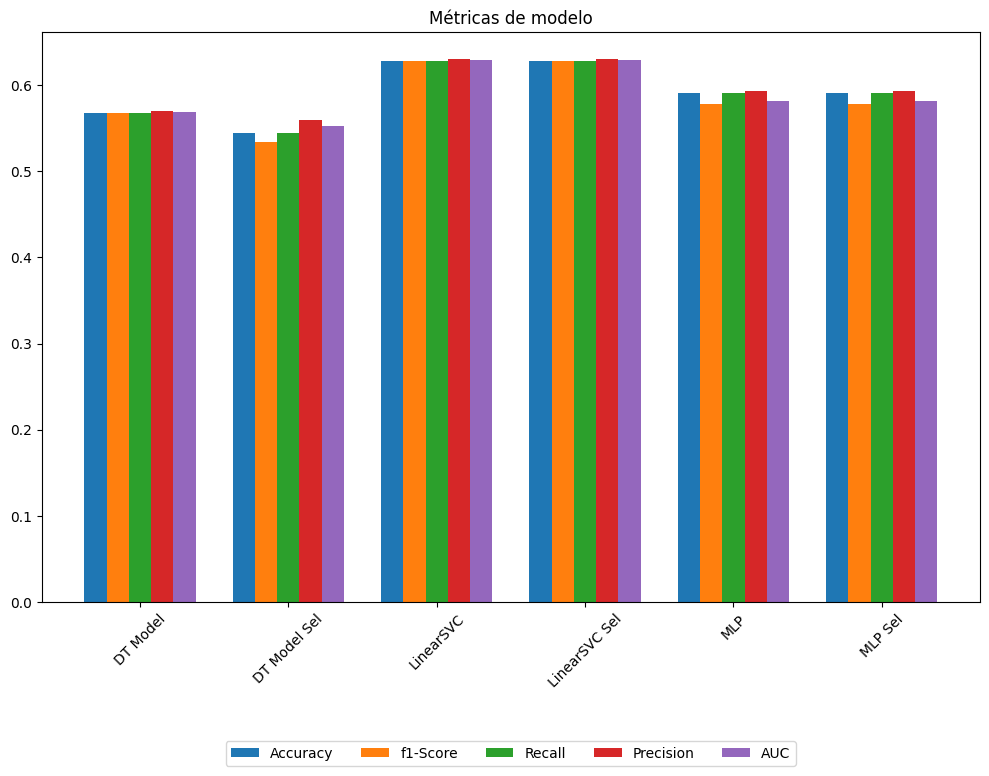

In [36]:
# Comparar en graficas todos los modelos
acc_values = [acc, accPlus, acc_svc, acc_svcPlus, acc_mlp, acc_mlpPlus]
f1_score = [f1, f1Plus, f1_svc, f1_svcPlus, f1_mlp, f1_mlpPlus]
precision = [weightedPrecision, weightedPrecisionPlus, weightedPrecision_svc,
             weightedPrecision_svcPlus, weightedPrecision_mlp, weightedPrecision_mlpPlus]
recall = [weightedRecall, weightedRecallPlus, weightedRecall_svc,
          weightedRecall_svcPlus, weightedRecall_mlp, weightedRecall_mlpPlus]
auc_values = [auc, aucPlus,auc_svc,auc_svcPlus,auc_mlp,auc_mlpPlus]

# Configuración del gráfico
fig = plt.figure(figsize=(10, 8)) # Tamaño del gráfico
ax = fig.add_subplot(111) # Añadir subplots

model_names = ['DT Model', 'DT Model Sel', 'LinearSVC', 'LinearSVC Sel', 'MLP', 'MLP Sel']
x_pos = np.arange(len(model_names))
bar_width = 0.15

# Crear las barras para cada métrica
acc_bars = ax.bar(x_pos - 2*bar_width , acc_values , bar_width , label='Accuracy')
f1_bars = ax.bar(x_pos - bar_width , f1_score , bar_width , label='f1-Score')
recall_bars = ax.bar(x_pos , recall , bar_width , label='Recall')
precision_bars = ax.bar(x_pos + bar_width , precision , bar_width , label='Precision')
auc_bars = ax.bar(x_pos + 2*bar_width , auc_values , bar_width , label='AUC')

# Agregar etiquetas de nombre de modelo en el eje x
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation=45)

# Agregar etiquetas de título y leyenda
ax.set_title('Métricas de modelo')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=5)

# Mostrar el gráfico
plt.tight_layout() # Evita que se superpongan los elementos del gráfico
plt.show()

### Se observa que para un conjunto de imágenes de 1000, todas las predicciones resultaron con métricas entre 0.5 y 0.6, siendo un poco mejor los de LinearSVM, de ambas opciones, se escoge el que menos tiempo tardó en el entrenamiento

## Ver imágenes ejemplo de las predicciones hechas por el modelo LinearSVM

In [37]:
grouped = classes.groupBy().agg(collect_list(struct('label', 'labelstr')).alias('classes'))
# Creamos un diccionario a partir de los valores agrupados en las clases identificadas al inicio
classes = {row.label: row.labelstr for row in grouped.select('classes').first().classes}
print(classes)

{0.0: 'Cat', 1.0: 'Dog'}


In [38]:
# hacer un zip con los label obtenidos en prediccion y los esperados para poder iterar a la par
# utilizar el predictions del modelo escogido
predicted_label = predictions_svcPlus.select("prediction")
predictions_new = predicted_label.collect()
label = [val.label for val in predictions_svcPlus.select('label').collect()]
predictions_new = [p[0] for p in predictions_new]
pred = zip(label, predictions_new)

Real:Dog 
Predicted:Dog


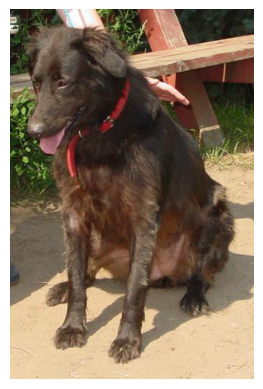

Real:Dog 
Predicted:Dog


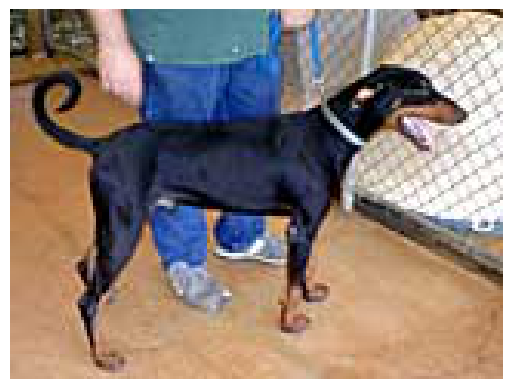

Real:Cat 
Predicted:Dog


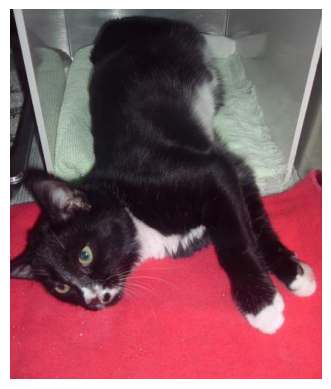

Real:Cat 
Predicted:Cat


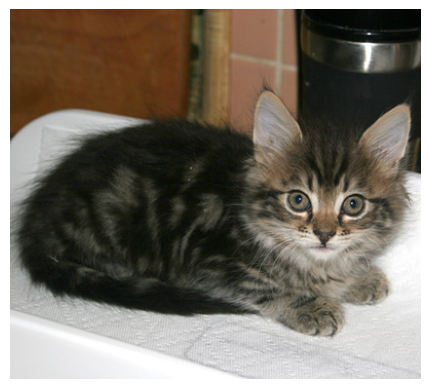

Real:Dog 
Predicted:Dog


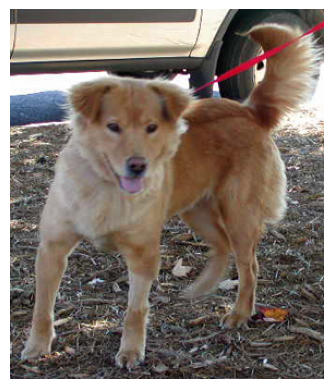

In [39]:
# Extraer path de las imagenes del conjunto de test para iterar
list_test_path = [x.image_path for x in predictions_svcPlus.select('image_path').rdd.map(lambda x: x).collect()]
#aplicar sample en list con menos img si son muchas las del conjuto de prueba
for p, img_path in sample(list(zip(pred,list_test_path)),5):
  print(f'Real:{classes[p[0]]} \nPredicted:{classes[p[1]]}')
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

## Matriz de confusión

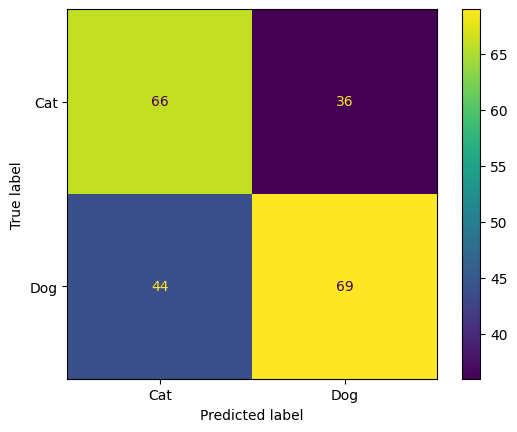

In [40]:
confusion_matrix = metrics.confusion_matrix([p[0] for p in zip(label, predictions_new)], [p[1] for p in zip(label, predictions_new)])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = classes.values()) #['Cat','Dog']
cm_display.plot()
plt.show()

## Guardar el modelo

In [41]:
svcModel.write().overwrite().save('/content/drive/MyDrive/MyModel')